# **Loading Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import required libraries
import pandas as pd

# Load the dataset
file_path = "/content/drive/My Drive/AML Project/training.1600000.processed.noemoticon.csv"
columns = ['polarity', 'id', 'date', 'query', 'user', 'text']
data = pd.read_csv(file_path, encoding='latin-1', names=columns)

# Select relevant columns
data = data[['polarity', 'text']]

# Map polarity to more intuitive labels
data['polarity'] = data['polarity'].map({0: 0, 2: 1, 4: 2})  # 0 = Negative, 1 = Neutral, 2 = Positive

# Check dataset information
print("Dataset loaded successfully!")
print(data.head())

Dataset loaded successfully!
   polarity                                               text
0         0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1         0  is upset that he can't update his Facebook by ...
2         0  @Kenichan I dived many times for the ball. Man...
3         0    my whole body feels itchy and like its on fire 
4         0  @nationwideclass no, it's not behaving at all....


# **Preprocessing**

In [ ]:
import re

# Text cleaning function
def clean_text(text):
    # Remove URLs, mentions, hashtags, and special characters
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Punctuation
    text = text.lower()  # Convert to lowercase
    return text

# Apply cleaning to the dataset
data['text'] = data['text'].apply(clean_text)

# Check the cleaned text
print("Cleaned text examples:")
print(data['text'].head())

Cleaned text examples:
0       a thats a bummer  you shoulda got david car...
1    is upset that he cant update his facebook by t...
2     i dived many times for the ball managed to sa...
3      my whole body feels itchy and like its on fire 
4     no its not behaving at all im mad why am i he...
Name: text, dtype: object


# **Data Splitting**

In [ ]:
from sklearn.model_selection import train_test_split

# Features (X) and labels (y)
X = data['text']
y = data['polarity']

# Split into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% training, 40% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Split temp into 50% validation and 50% test

# Check the sizes of each split
print(f"Training examples: {len(X_train)}")
print(f"Validation examples: {len(X_val)}")
print(f"Testing examples: {len(X_test)}")

Training examples: 960000
Validation examples: 320000
Testing examples: 320000


# **Feature Extraction**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the training data, transform the validation and test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Check the shape of the resulting feature matrices
print(f"Training set features: {X_train_tfidf.shape}")
print(f"Validation set features: {X_val_tfidf.shape}")
print(f"Testing set features: {X_test_tfidf.shape}")

Training set features: (960000, 5000)
Validation set features: (320000, 5000)
Testing set features: (320000, 5000)


# **Model Development and Training**

# Classification (Logistic Regression)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Logistic Regression Model
lr_model = Sequential([
    Flatten(input_shape=(max_length,)),  # Flatten the padded sequence
    Dense(3, activation='softmax')       # Output layer with 3 classes
])

# Compile
lr_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
lr_history = lr_model.fit(
    X_train_pad,
    y_train_tf,
    validation_data=(X_val_pad, y_val_tf),
    epochs=5,
    batch_size=256,
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.4760 - loss: 99.8225 - val_accuracy: 0.4963 - val_loss: 1.5402
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.5020 - loss: 1.6696 - val_accuracy: 0.4928 - val_loss: 1.5833
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.4990 - loss: 1.6723 - val_accuracy: 0.4968 - val_loss: 1.6441
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.5007 - loss: 1.6455 - val_accuracy: 0.4949 - val_loss: 2.2348
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.5011 - loss: 1.6488 - val_accuracy: 0.5024 - val_loss: 1.6902


# CNN

In [ ]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

# CNN Model
cnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Conv1D(128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
cnn_history = cnn_model.fit(
    X_train_pad,
    y_train_tf,
    validation_data=(X_val_pad, y_val_tf),
    epochs=5,
    batch_size=256,
    verbose=1
)

Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.7765 - loss: 0.4629 - val_accuracy: 0.8200 - val_loss: 0.3954
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - accuracy: 0.8396 - loss: 0.3603 - val_accuracy: 0.8209 - val_loss: 0.3928
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - accuracy: 0.8658 - loss: 0.3112 - val_accuracy: 0.8173 - val_loss: 0.4084
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.8906 - loss: 0.2596 - val_accuracy: 0.8125 - val_loss: 0.4533
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.9111 - loss: 0.2138 - val_accuracy: 0.8069 - val_loss: 0.5259


# LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

# LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
lstm_history = lstm_model.fit(
    X_train_pad,
    y_train_tf,
    validation_data=(X_val_pad, y_val_tf),
    epochs=5,
    batch_size=256,
    verbose=1
)

Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 56s 14ms/step - accuracy: 0.5004 - loss: 0.6980 - val_accuracy: 0.4998 - val_loss: 0.6933
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - accuracy: 0.4996 - loss: 0.6935 - val_accuracy: 0.5002 - val_loss: 0.6932
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - accuracy: 0.4994 - loss: 0.6933 - val_accuracy: 0.5002 - val_loss: 0.6933
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - accuracy: 0.5006 - loss: 0.6932 - val_accuracy: 0.4998 - val_loss: 0.6932
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.4998 - val_loss: 0.6932


# Model Comparison

In [ ]:
# Evaluate all models
lr_val_loss, lr_val_acc = lr_model.evaluate(X_val_pad, y_val_tf, verbose=1)
cnn_val_loss, cnn_val_acc = cnn_model.evaluate(X_val_pad, y_val_tf, verbose=1)
lstm_val_loss, lstm_val_acc = lstm_model.evaluate(X_val_pad, y_val_tf, verbose=1)

# Print Results
print(f"Logistic Regression - Validation Accuracy: {lr_val_acc}")
print(f"CNN - Validation Accuracy: {cnn_val_acc}")
print(f"LSTM - Validation Accuracy: {lstm_val_acc}")

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.5028 - loss: 1.6785
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.8065 - loss: 0.5247
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 0.5000 - loss: 0.6932
Logistic Regression - Validation Accuracy: 0.5024437308311462
CNN - Validation Accuracy: 0.8068687319755554
LSTM - Validation Accuracy: 0.4998093843460083


# **Visualization and Interpretability**

# CNN

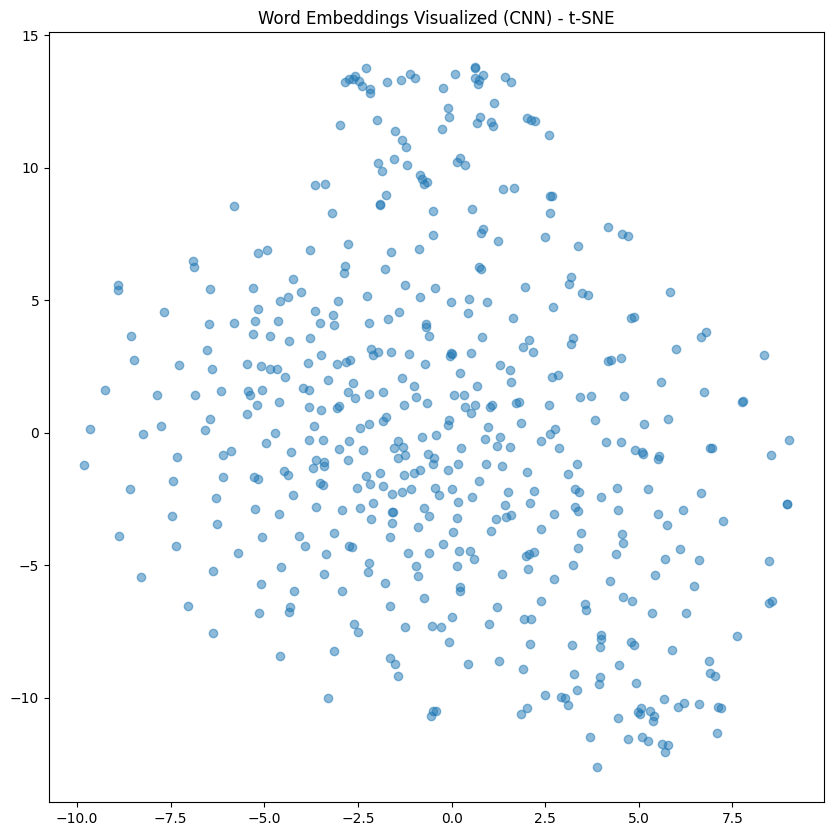

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract CNN embedding layer weights (correct layer name is 'embedding_2')
embedding_layer_cnn = cnn_model.get_layer('embedding_2')  # Use 'embedding_2' instead of 'embedding'
weights_cnn = embedding_layer_cnn.get_weights()[0]

# Reduce dimensionality using t-SNE
tsne_cnn = TSNE(n_components=2, random_state=42)
reduced_embeddings_cnn = tsne_cnn.fit_transform(weights_cnn[:500])  # Limit to first 500 words for faster computation

# Visualization
plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings_cnn[:, 0], reduced_embeddings_cnn[:, 1], alpha=0.5)
plt.title("Word Embeddings Visualized (CNN) - t-SNE")
plt.show()

# LSTM

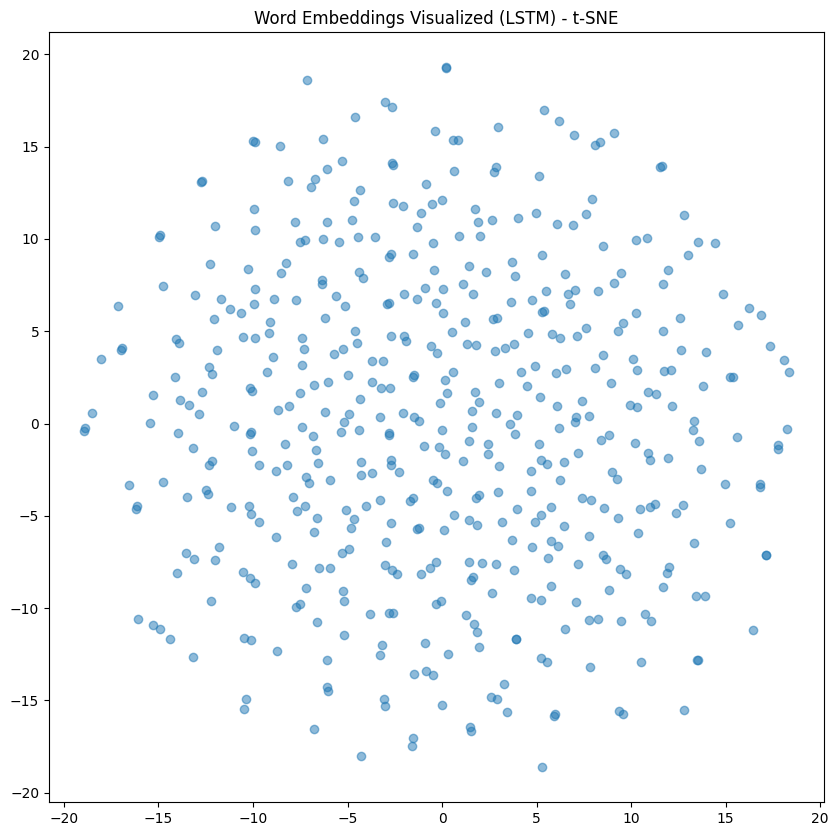

In [ ]:
# Extract LSTM embedding layer weights (correct layer name is 'embedding_3')
embedding_layer_lstm = lstm_model.get_layer('embedding_3')  # Use 'embedding_3' instead of 'embedding'
weights_lstm = embedding_layer_lstm.get_weights()[0]

# Reduce dimensionality using t-SNE
tsne_lstm = TSNE(n_components=2, random_state=42)
reduced_embeddings_lstm = tsne_lstm.fit_transform(weights_lstm[:500])  # Limit to first 500 words for faster computation

# Visualization
plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings_lstm[:, 0], reduced_embeddings_lstm[:, 1], alpha=0.5)
plt.title("Word Embeddings Visualized (LSTM) - t-SNE")
plt.show()